## CALIBRAGE DE DONNEES D'EVOLUTION DES DEUX ESPECES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
data = pd.read_excel('id_param.xlsx')
data.head()

jour  p_aurelia  p_coudatoum
0     0        2.0          2.0
1     1        NaN          NaN
2     2       14.0         10.0
3     3       34.0         10.0
4     4       36.0         11.0

##### a. Nuages de points

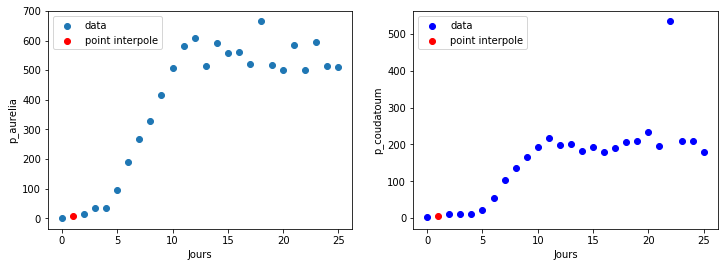

In [56]:
# Tracé des nuages de points

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.scatter(data['jour'], data['p_aurelia'], label='data')
plt.scatter(1,8,c='r',label='point interpole')
plt.xlabel('Jours')
plt.ylabel('p_aurelia')
plt.legend()

plt.subplot(122)
plt.scatter(data['jour'], data['p_coudatoum'], c='b', label='data')
plt.scatter(1,6,c='r',label='point interpole')
plt.xlabel('Jours')
plt.ylabel('p_coudatoum')
plt.legend()

In [57]:
# Suppréssion des données manquantes
data = data.dropna(axis=0)
data.head()

jour  p_aurelia  p_coudatoum
0     0        2.0          2.0
2     2       14.0         10.0
3     3       34.0         10.0
4     4       36.0         11.0
5     5       94.0         21.0

### Interpolation des données manquantes

In [58]:
# Interpolation des données manquantes

from scipy import interpolate
f_linear = interpolate.interp1d(data['jour'], data['p_aurelia']) 
g_linear = interpolate.interp1d(data['jour'], data['p_coudatoum'])

df = pd.DataFrame({
                    "jour": [1],
                    'p_aurelia': [f_linear(1)],
                    'p_coudatoum': [g_linear(1)]
                   })
df

jour p_aurelia p_coudatoum
0     1       8.0         6.0

In [59]:
# Données Completes

data = pd.read_excel('id_p.xlsx')
data.head()

jour  p_aurelia  p_coudatoum
0     0          2            2
1     1          8            6
2     2         14           10
3     3         34           10
4     4         36           11

##### b. Matrices H de differentes espèces et vecteurs N

# 1. Modèle logistique


#     $ N' = rN(1-\frac NK) $  
#### Il s'écrit encore sous la forme $N = H\theta$  où 
\begin{equation*}
H = 
\begin{pmatrix}
N_{0} & N_{0}^2 \\
N_{1} & N_{1}^2 \\
\vdots & \vdots \\
N_{24} & N_{24}^2
\end{pmatrix}
\end{equation*}

\begin{equation*}
\theta = 
\begin{pmatrix}
1 + r \\
-\frac{r}{K}
\end{pmatrix}
\end{equation*}

\begin{equation*}
N = 
\begin{pmatrix}
N_{1} \\
N_{2} \\
\vdots \\
N_{25} \\
\end{pmatrix}
\end{equation*}

In [60]:
N_a = data.loc[1:, ['p_aurelia']].values
N_c = data.loc[1:, ['p_coudatoum']].values

In [67]:
p_c = data.loc[0:24, ['p_coudatoum']].values
p_a = data.loc[0:24, ['p_aurelia']].values
jours = data.loc[0:24, ['jour']].values

H_a = np.concatenate((p_a, p_a**2), axis=1)
H_c = np.concatenate((p_c, p_c**2), axis=1)
p_a.shape

(25, 1)

##### c. Modèle 

In [68]:
def model(H, theta):
    return np.dot(H,theta)

##### d. Résidus

In [69]:
def residues(N, theta, H):
    return np.sum((N-model(H,theta))**2)

##### e. Estimateur de theta par les MCO

In [70]:
# Initialisation de theta pour l'algo de descente du gradient

#theta = np.random.randn(2, 1)
#theta

In [71]:
def grad(H, theta, N):
    return H.T.dot(model(H, theta)-N)

In [72]:
def cost_function(H, N, theta):
    return np.sum((model(H, theta)-N)**2) 

In [73]:
def gradient_descent(H, N, theta, learning_rate, n_iteration):
    cost_history = np.zeros(n_iteration)
    for i in range(0, n_iteration):
        theta = theta - learning_rate*grad(H, theta, N)
        cost_history[i] = cost_function(H, N, theta)
        
    return theta, cost_history

In [74]:
def estimator(H, N):
    theta = np.linalg.inv(H.T.dot(H)).dot(H.T).dot(N)
    return theta

In [75]:
#theta_a, cost_history_a = gradient_descent(H_a, N_a, theta, learning_rate=0.01, n_iteration=500)
#theta_c, cost_history_b = gradient_descent(H_c, N_c, theta, learning_rate=0.01, n_iteration=500)

##### f. Tracé de modèles calibrés

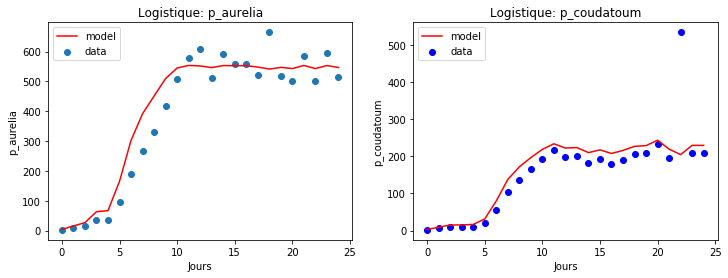

In [76]:
theta_a = estimator(H_a, N_a)
theta_c = estimator(H_c, N_c)
model_a = model(H_a, theta_a)
model_c = model(H_c, theta_c)

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.scatter(jours, p_a, label='data')
plt.xlabel('Jours')
plt.ylabel('p_aurelia')
plt.plot(jours, model_a, c='r',label='model')
plt.title('Logistique: p_aurelia')
plt.legend()

plt.subplot(122)
plt.scatter(jours, p_c, c='b', label='data')
plt.xlabel('Jours')
plt.ylabel('p_coudatoum')
plt.plot(jours, model_c, c='r', label='model')
plt.title('Logistique: p_coudatoum')
plt.legend()

###### Résidus du modèle Logistique

In [77]:
residus_a, residus_c = residues(N_a, theta_a, H_a),residues(N_c, theta_c, H_c)
reslogist = [residus_a, residus_c]
reslogist

[44199.16723453691, 111360.82062711504]

# 2. Modèle de Gompertz

## $ N' = rln\left (\frac{K}{N} \right) $  
#### Il s'écrit encore sous la forme matricielle  $N = H\theta$   où 
\begin{equation*}
H = 
\begin{pmatrix}
N_{0} & -lnN_{0} & 1 \\
N_{1} & -lnN_{1} & 1 \\
\vdots & \vdots & \vdots \\
N_{24} & -lnN_{24} & 1 \\
\end{pmatrix}
\end{equation*}

\begin{equation*}
\theta = 
\begin{pmatrix}
1 \\
r \\
rlnK
\end{pmatrix}
\end{equation*}

\begin{equation*}
N = 
\begin{pmatrix}
N_{1} \\
N_{2} \\
\vdots \\
N_{25} \\
\end{pmatrix}
\end{equation*}

In [78]:
#data = data.dropna(axis=0)
from math import *

In [79]:
H1 = np.concatenate((p_a, -np.log(p_a)), axis=1)
H_a = np.hstack((H1, np.ones((25, 1))))

H2 = np.concatenate((p_c, -np.log(p_c)), axis=1)
H_c = np.hstack((H2, np.ones((25, 1))))
H1.shape

(25, 2)

In [80]:
theta_a = estimator(H_a, N_a)
theta_c = estimator(H_c, N_c)
model_a = model(H_a, theta_a)
model_c = model(H_c, theta_c)

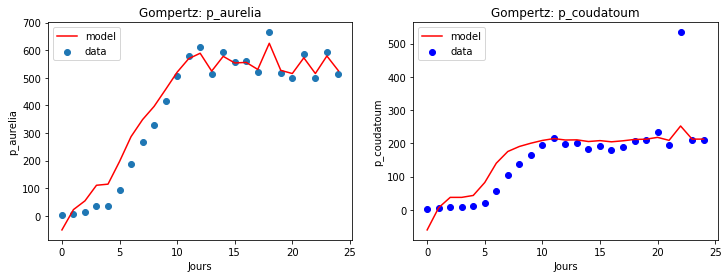

In [81]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.scatter(jours, p_a, label='data')
plt.xlabel('Jours')
plt.ylabel('p_aurelia')
plt.plot(jours, model_a, c='r', label='model')
plt.title('Gompertz: p_aurelia')
plt.legend()

plt.subplot(122)
plt.scatter(jours, p_c, c='b', label='data')
plt.xlabel('Jours')
plt.ylabel('p_coudatoum')
plt.plot(jours, model_c, c='r', label='model')
plt.title('Gompertz: p_coudatoum')
plt.legend()

###### Résidus Gompertz

In [82]:
residus_a, residus_c = residues(N_a, theta_a, H_a), residues(N_c, theta_c, H_c)
resGptz = [residus_a, residus_c]
resGptz

[82286.72623165074, 122497.69307813705]

# 3. Modèle de Bernouilli

## $ N' = r(1- \left(\frac{N}{K} \right)^\theta) $  
#### Il s'écrit encore sous la forme matricielle  $N = H\theta$   où 
\begin{equation*}
H = 
\begin{pmatrix}
-lnN_{0} & 1 \\
-lnN_{1} & 1 \\
\vdots & \vdots \\
-lnN_{24} & 1 \\
\end{pmatrix}
\end{equation*}

\begin{equation*}
N = 
\begin{pmatrix}
N_{1} \\
N_{2} \\
\vdots \\
N_{25} \\
\end{pmatrix}
\end{equation*}

In [83]:
H_a = np.hstack((-np.log(p_a), np.ones((25, 1))))
H_c = np.hstack((np.log(p_c), np.ones((25, 1))))
H_c.shape

(25, 2)

In [84]:
theta_a = estimator(H_a, N_a)
theta_c = estimator(H_c, N_c)
model_a = model(H_a, theta_a)
model_c = model(H_c, theta_c)

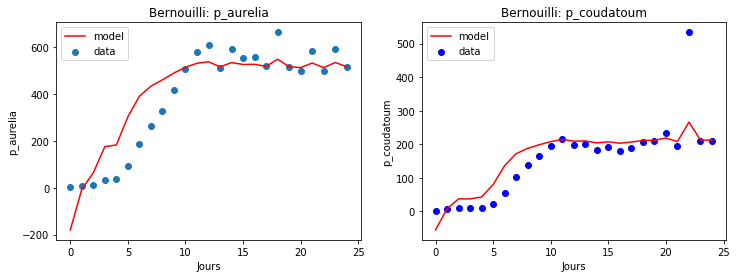

In [85]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.scatter(jours, p_a, label='data')
plt.xlabel('Jours')
plt.ylabel('p_aurelia')
plt.plot(jours, model_a, c='r', label='model')
plt.title('Bernouilli: p_aurelia')
plt.legend()

plt.subplot(122)
plt.scatter(jours, p_c, c='b', label='data')
plt.xlabel('Jours')
plt.ylabel('p_coudatoum')
plt.plot(jours, model_c, c='r', label='model')
plt.title('Bernouilli: p_coudatoum')
plt.legend()

###### Résidus Bernouilli

In [86]:
residus_a, residus_c = residues(N_a, theta_a, H_a), residues(N_c, theta_c, H_c)
resBnli = [residus_a, residus_c]
resBnli

[160523.84506873763, 122770.39907076595]